Consider the standard regression probelem. We have some observed data $\mathcal{D} = [(\mathbf{x}_1, y_1) \dots (\mathbf{x}_n, y_n)]$ with $\mathbf{x} \in \mathbb{R}^D$ and $y \in \mathbb{R}$, and we want to predict the unkown $y_*$ corresponding to some new test point $\mathbf{x}_*$. If we assume the underlying function $y=f(\mathbf{x})$ that generated $\mathcal{D}$ is linear, then we can simply use the least-squares method to draw a line-of-best-fit and thus arrive at our estimate for $y_*$.

Of course the assumption of a linear model will not normally be valid. To lift this restriction, a simple trick is to project the inputs $\mathbf{x} \in \mathcal{R}^D$ into some higher dimensional space $\mathbf{\phi}(\mathbf{x}) \in \mathcal{R}^M$, where $M > D$, and then apply the above linear model in this space rather than on the inputs themselves. For example, a scalar input $x \in \mathcal{R}$ could be projected into the space of powers of $x$: $\phi({x}) = (1, x, x^2, x^3, \dots x^{M-1})^T$. By applying our linear model now on $\phi(x)$ rather than directly on the inputs $x$, i.e. $y=f(\phi(x))$, we would implicitly be performing polynomial regression in the input space. 

By selecting alternative components (a.k.a basis functions) for $\phi(\mathbf{x})$ we can perform regression of more complex functions. But how do we choose the basis functions? In a Gaussian Process Regression (GPR), we need not specify the basis functions explicitly. Rather, we make some more general assumptions about $f(\mathbf{x})$, and allow the data to inform the choice instead. This is a key advantage of GPR over other types of regression.

A GP simply generalises the definition of a multivariate Gaussian distribution to incorporate infinite dimensions: a GP is a set of random variables, any finite subset of which are multivariate Gaussian distributed. More formally, for any index set $\mathcal{X}$, a GP on $\mathcal{X}$ is a set of random variables $(z_t) = \{z_t: t \in \mathcal{X}\}$ s.t. $\forall n \in \mathcal{N}, \forall x_1, \dots x_n \in \mathcal{X}$, $(z_{x_1} \dots z_{x_n})$ is multivariate Gaussian distributed.  The definition doesn't actually exclude finite index sets, but a G.P defined over a finite index set would simply be a multivariate Gaussian distribution, and would normally be named as such. 

In our case the random variables are the function values $f(\mathbf{x})$ corresponding to all possible input points $\mathbf{x}$. Since we assume any $n$-element subset of these random variables to be $n$-variate Gaussian distributed, our observations $\{y_1, \dots, y_n\}$ can be imagined as a single point drawn from an $n$-variate Gaussian distribution.

Whilst a multivariate Gaussian distribution is completely specified by a single (finite dimensional) mean vector and covaraince matrix, in a G.P this is not possible, since the finite dimensional distributions in terms of which it is defined can have an arbitrary number of dimensions. Instead we specify the G.P in terms of elementwise mean and covariance functions, $m(\mathbf{x})$ and $k(\mathbf{x}, \mathbf{x}')$, from which the mean vectors and covariance matrices of all possible finite dimensional distributions can be constructed.
$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$.

 Any covariance function is valid so long it defines a valid covariance matrix i.e. one that is positive semi-definite. This makes G.Ps particularly flexible and poweful models. Usually the mean function is chosen to be zero.

OK, time for a some examples. First let's start building a simple GPR class to experiment with. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [8]:
kernels = {
    'linear': lambda x1, x2: np.dot(x1.T, x2),
    'squared_exponential': lambda x1, x2: 1.95 * np.exp(-1.02 * np.dot((x1 - x2).T, (x1 - x2))),
    'periodic': lambda x1, x2: np.exp(-np.sin( 1 * np.pi * (x1 - x2)) ** 2)
}

In [9]:
class GPR():
    
    def __init__(self, kernel, noise_variance=1e-10):
        self.kernel = kernel
        self.noise_variance = noise_variance
        
    def _build_covariance_matrix(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        C = np.zeros((X1.shape[0] , X2.shape[0]))
        for i in range(X1.shape[0]):
            for j in range(X2.shape[0]):
                C[i, j] = self.kernel(X1[i], X2[j])
        return C
    
    def sample_y(self, X, n_samples=1):
        y_mean = np.zeros(X.shape[0])
        y_cov = self._build_covariance_matrix(X)
        y_cov[np.diag_indices_from(y_cov)] += self.noise_variance
        try:
            L = np.linalg.cholesky(y_cov)
        except np.linalg.LinAlgError as e:
            e.args = ("The kernel, %s, is not returning a" 
                      "positive definite matrix. Try increasing"
                      "the noise variance"
                      % self.kernel,) + e.args
            raise
        u = np.random.randn(X.shape[0], n_samples)
        z = np.dot(L, u) + y_mean[:, np.newaxis]
        return z

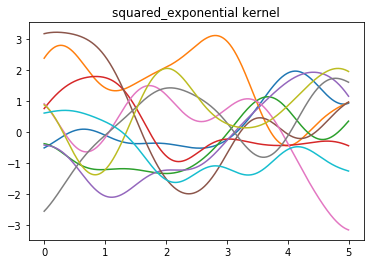

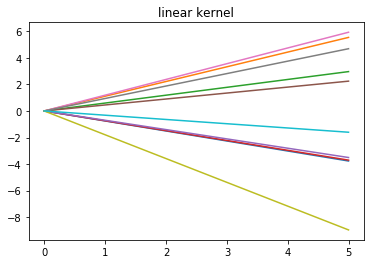

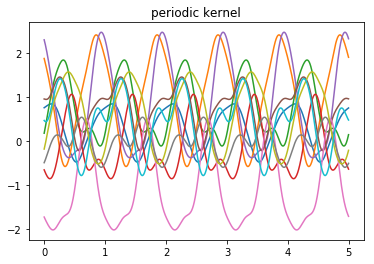

In [10]:
X = np.arange(0, 5, 0.005)[:, np.newaxis]
n_samples = 10
for kernel_name, kernel_fn in kernels.items():
    gp = GPR(kernel_fn)
    y_sampled = gp.sample_y(X, n_samples)
    plt.plot(X, y_sampled)
    plt.title('{} kernel'.format(kernel_name))
    plt.show()

So far we have only drawn random functions from the G.P prior. In order to make meaningful predictions, we first need to restrict this prior distribution to contain only those functions that agree with the observed data. In other words we need to form the G.P posterior. 

Consider that in addition to the $n$ observations defined above, we have $n_*$ test inputs, for which we want to know the corresponding outputs $f_*$. Using the marginalisation property of multivariate Gaussians, the joint distribution over the observed outputs, $\mathbf{f}$, and test ouputs $\mathbf{f_*}$ according to the G.P prior is
$\begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} = \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} K(X, X) && K(X, X_*) \\ K(X_*, X) && K(X_*, X_*)\end{bmatrix}\right)$.

The G.P posterior is found by conditioning the joint G.P prior distribution on the observations
$\mathbf{f}_* | X_*, X, \mathbf{f} \sim \mathcal{N}\left(K(X_*, X)K(X, X)^{-1}\mathbf{f}, K(X_*, X_*) - K(X_*, X)K(X, X)^{-1}K(X, X_*)\right)$.

Let's take a simple example. Take $m(\mathbf{x})=0$ and $k(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^T\mathbf{x}_j$. $\mathcal{X} \in \mathcal{R}^d$. $k(\mathbf{x}_i, \mathbf{x}_j)$ is a valid covariance function since .

Let's take a simple example. Consider the following GP: $z_\mathbf{x}=\mathbf{x}^T\mathbf{w}$, where $\mathcal{X}=\mathcal{R}^d$, $\mathbf{x} \in \mathcal{X}$, and $\mathbf{w} \in \mathcal{R}^d \sim \mathcal{N}(0, I)$. To show that this defines a valid G.P, we need to show that any finite subset of these random variables is multivariate Gaussian distributed. Consider a subset of $n$ such random variables:
$\mathbf{z} = \mathbf{X}\mathbf{w}$, where $\mathbf{z} = \begin{pmatrix}z_{\mathbf{x}_1} \\ \vdots \\ z_{\mathbf{x}_n} \end{pmatrix}$ and  $\mathbf{X}= \begin{pmatrix}\mathbf{x}_1^T \\ \vdots \\ \mathbf{x}_n^T \end{pmatrix}$. By the affine property of multivariate Gaussians, $\mathbf{z}$ is indeed multivariate ($n$-variate) Gaussian distributed with $\text{E}[\mathbf{z}] = \mathbf{0}$ and $\text{Cov}[\mathbf{z}] = \mathbf{X}\mathbf{X}^T$.

Sampling from this G.P is as easy as sampling from an $n$-variate multivariate Gaussian distribution (where $n$ can be any number $n \in \mathcal{N}$). 

In [ ]:
import numpy as np
X = np.arange(0, 5, 0.005)[:, np.newaxis]

In [ ]:
X.shape

In [ ]:
n = X.shape[0]
y_mean = np.zeros(n)
y_cov = np.dot(X, X.T) + 1e-10*np.eye(X.shape[0])

L = np.linalg.cholesky(y_cov)
u = np.random.randn(n, 50)
z = np.dot(L, u) + y_mean[:, np.newaxis]

In [ ]:
z.shape

### Bayesian Linear Regression -> GP Regression

The standard Bayesian linear regression model with Gaussian noise is:
$$ f(\mathbf{x}) = \mathbf{x}^T \mathbf{w}, \quad y = f(\mathbf{x}) + \epsilon $$
with
$$ \mathbf{w} \sim \mathcal{N}(0, \Sigma_{p}) \quad \text{and} \quad \epsilon \sim \mathcal{N}(0, \sigma^{2}I) $$

Bay
$$x=\sqrt{a^2 + b^2}$$

In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.optimize import minimize
import warnings

In [ ]:
class GPR():
    def __init__(self, kernel, optimizer, noise_var=1e-10):
        self.kernel = kernel
        self.optimizer = optimizer
        self.noise_var = noise_var
        
    def fit(self, X, y, eval_gradient=True):
        pass
    def predict(self, X):
        pass
    def sample_y(self, X, n_samples):
        pass
    def log_marginal_likelihood(self, theta=None, eval_gradient=None):
        pass

In [ ]:
class RBF():
    
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
    
    def __call__(self, X1, X2=None, eval_gradient=False):
        if X2 is None:
            # Upper triangular pair-wise distances
            dists = pdist(X1/self.length_scale, 'sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)  # copy upper-triangle to lower-triangle
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError(
                    "Should only be evaluating gradient when X2 is None.")
            dists = cdist(X1/self.length_scale, X2/self.length_scale, 
                          metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            
        if eval_gradient:
            # Note scipy implementation doesn't divide by self.length_scale but
            # I think this is wrong.
            K_gradient = (K * squareform(dists))[:, :, np.newaxis] / self.length_scale 
            return K, K_gradient
        else:
            return K
    
    def theta(self):
        return np.array([self.length_scale])
    
    def set_theta(self, theta):
        [self.length_scale] = theta
        
    def bounds(self):
        return [self.length_scale_bounds]

In [ ]:
def fit(self, X, y, eval_gradient=True):
    
    # demean our observations and take this mean for GP prior 
    # (realized in computing predictive mean eqn. 2.25)
    self._y_train_mean = np.mean(y, axis=0)
    y = y - self._y_train_mean
    
    self.X_train_ = np.copy(X)
    self.y_train_ = np.copy(y)
    self.kernel_ = copy.copy(self.kernel)  # same as prior kernel 
    # but with parameters to be optimized
    
    def obj_func(theta, eval_gradient):
        if eval_gradient:
            lml, grad = self.log_marginal_likelihood(theta, eval_gradient=True)
            return -lml, -grad
        else:
            return -self.log_marginal_likelihood(theta)
    results = minimize(obj_func, 
                       self.kernel_.theta(), 
                       args=(eval_gradient), 
                       method=self.optimizer, 
                       jac=eval_gradient,
                       bounds=self.kernel_.bounds())
    self.log_marginal_likelihood_value = -results['fun']
    self.kernel_.set_theta(results['x'])
    
    # compute alpha of eqn. 2.25, needed for making predictions and computing lml
    K = self.kernel_(self.X_train_)
    K[np.diag_indices_from(K)] += self.noise_var
    try:
        self.L_ = np.linalg.cholesky(K)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix. Try gradually "
                 "increasing the 'alpha' parameter of your "
                    "GaussianProcessRegressor estimator."
                  % self.kernel_,) + e.args
        raise
        
    self.alpha_ = np.linalg.solve(self.L_.T, np.linalg.solve(self.L_, self.y_train_))
    
    return results['success']

GPR.fit = fit

In [ ]:
def predict(self, X):
    """ Returns predictive mean and variance."""
    if not hasattr(self, "X_train_"):  # Unfitted; predict based on GP prior.
        y_mean = np.zeros(X.shape[0])
        y_cov = self.kernel(X)
        return y_mean, y_cov
    else:  # Predict based on GP posterior using kernel with optimized params
        K_trans = self.kernel_(X, self.X_train_)
        y_mean = K_trans.dot(self.alpha_)  # Line 4 (y_mean = f_star)
        y_mean = self._y_train_mean + y_mean  # undo normal.

        v = np.linalg.solve(self.L_, K_trans.T)  # self.L_.T * K_inv * K_trans.T
        y_cov = self.kernel_(X) - np.dot(v.T, v)  # Line 6
        
        # Add jitter to avoid numerical issues
        y_cov[np.diag_indices_from(y_cov)] += 1e-10
      
        return y_mean, y_cov
GPR.predict = predict

In [ ]:
def sample_y(self, X, n_samples=1):
    y_mean, y_cov = self.predict(X)
    
    # z = np.random.multivariate_normal(y_mean, y_cov, n_samples).T  
    try:
        L = np.linalg.cholesky(y_cov)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix."
                  % self.kernel,) + e.args
        raise
    u = np.random.randn(X.shape[0], n_samples)
    z = np.dot(L, u) + y_mean[:, np.newaxis]
    return z
GPR.sample_y = sample_y

In [ ]:
def log_marginal_likelihood(self, theta=None, eval_gradient=False, noise_var=None):
    
    if noise_var is None:
        noise_var = self.noise_var
        
    if theta is None:
        assert hasattr(self, "log_marginal_likelihood_value")
        print('Using fitted theta')
        return self.log_marginal_likelihood_value
    
    kernel = copy.deepcopy(self.kernel)
    kernel.set_theta(theta)
    
    if eval_gradient:
        K, K_gradient = kernel(self.X_train_, eval_gradient=True)
    else:
        K = kernel(self.X_train_)
        
    K[np.diag_indices_from(K)] += noise_var
       
    # Compute L and alpha for this K (theta)
    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return (-np.inf, np.zeros_like(theta)) if eval_gradient else -np.inf

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train_))
        
    # Compute log-likelihood (eqn. 2.30)
    log_likelihood = -0.5 * np.einsum("i,i", self.y_train_, alpha)
    log_likelihood -= np.log(np.diag(L)).sum()
    log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)

    if eval_gradient:
        # Compute lml gradient w.r.t kernel params (eqn. 5.9)
        tmp = np.einsum("i,j->ij", alpha, alpha)
        tmp -= np.linalg.solve(L.T, np.linalg.solve(L, np.eye(K.shape[0])))  # K inverse
        log_likelihood_gradient = 0.5 * np.einsum("ij,ijk->k", tmp, K_gradient)
    
    if eval_gradient:
        return log_likelihood, log_likelihood_gradient
    else:
        return log_likelihood
GPR.log_marginal_likelihood = log_marginal_likelihood

In [ ]:
X = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
kernel = RBF(length_scale=1)
gp = GPR(kernel, 'L-BFGS-B', noise_var=1e-10)

In [ ]:
# Sample from prior and take as observations
y_sample = gp.sample_y(X)

In [ ]:
y_sample.shape

In [ ]:
%%capture
fig, ax = plt.subplots()

In [ ]:
ax.plot(X, y_sample, 'r+')
ax.set_xlim(-5, 5)
ax.set_ylim(-2.5, 2.5)
fig

In [ ]:
X_test = np.arange(-5, 5, 0.005)[:, np.newaxis]

In [ ]:
gp.fit(X, y_sample[:, 0], True)

In [ ]:
gp.kernel_.theta()

In [ ]:
gp.kernel.theta()

In [ ]:
y_pred_mean, y_pred_covar = gp.predict(X_test)

In [ ]:
ax.plot(X_test, y_pred_mean, 'b')
fig

In [ ]:
# compute 95% confidence interval from pointwise variances and plot
pointwise_variances = y_pred_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
ax.fill_between(X_test[:, 0], y_pred_mean - error, y_pred_mean + error, alpha=0.3)
fig

In [ ]:
y_pred_sample = gp.sample_y(X_test, n_samples=5)

In [ ]:
for i in range(y_pred_sample.shape[1]):
    ax.plot(X_test, y_pred_sample[:, i])
fig

In [ ]:
gp.log_marginal_likelihood()

In [ ]:
# Plot log marginal likelihood w.r.t. different values of theta
length_scales = np.linspace(0.90, 1.2, 100)
noise_variance = np.linspace(1e-11, 1e-4, 100)
X, Y = np.meshgrid(length_scales, noise_variance)

In [ ]:
X.shape

In [ ]:
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(theta=[x[0]], noise_var=x[1]), list(zip(X.ravel(), Y.ravel())))))

In [ ]:
Z = Z.reshape((X.shape))

In [ ]:
Z.shape

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)